In [2]:
import numpy as np
from utils.xai_utils import integrated_gradients, reshape_gwn_output
from utils.models import gwnet, reshape_for_gwn
import torch
import matplotlib.pyplot as plt
plt.style.use('dark_background')

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [3]:
data = np.load("../../river-dl/results/baseline/GWN/prepped.npz")
data = reshape_for_gwn(data,keep_portion= 15)
adj_mx = data['dist_matrix']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
supports = [torch.tensor(adj_mx).to(device).float()]
in_dim = len(data['x_vars'])
out_dim = data['y_obs_trn'].shape[3]
num_nodes = adj_mx.shape[0]

# Load our model

In [4]:
model = gwnet(device,num_nodes,supports=supports,aptinit=supports[0],
    in_dim=in_dim,out_dim=out_dim,layers=3, kernel_size=5,blocks=3)
model.load_state_dict(torch.load('../../river-dl/results/baseline/GWN/rep_5/finetuned_weights.pth', map_location='cpu'))

<All keys matched successfully>

# Define a manual/custom implementation of Integrated Gradients


In [5]:
x = torch.from_numpy(data['x_trn']).float() # use the last year of data for all 455 segments
baseline = torch.mean(x,dim=0).unsqueeze(dim=0)
x = x[0:1]
model.eval()

x.shape, baseline.shape, model(x[0:1]).shape

(torch.Size([1, 7, 455, 60]),
 torch.Size([1, 7, 455, 60]),
 torch.Size([1, 1, 455, 15]))

In [6]:
from utils.xai_utils import reshape_gwn_output
dummy_out = model(x[0:1])
dummy_reshped = reshape_gwn_output(dummy_out)
dummy_out.shape, dummy_reshped.shape

(torch.Size([1, 1, 455, 15]), torch.Size([455, 15, 1]))

## Set up our baseline and sequence of interest

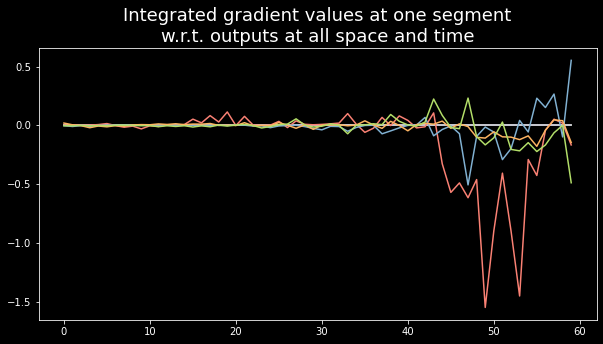

In [7]:
#from utils.xai_utils import integrated_gradients

IG_vals = integrated_gradients(x, model, 2, baseline,gwn=True)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

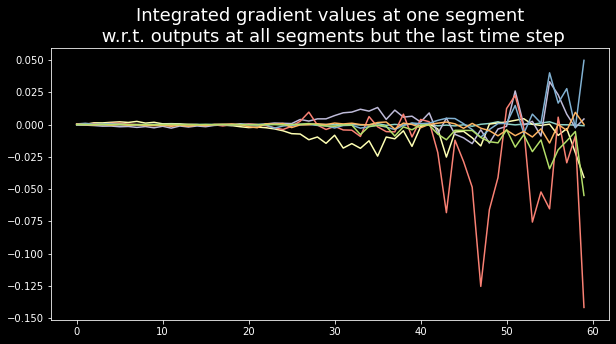

In [8]:
IG_vals = integrated_gradients(x, model, 2, torch.zeros_like(x), temporal_focus = -1,gwn=True)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\n w.r.t. outputs at all segments but the last time step',
          fontsize = 18);

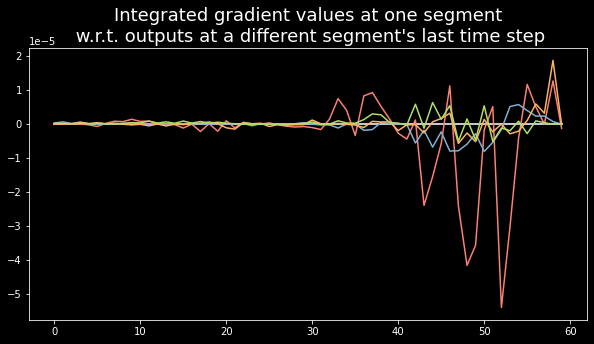

In [9]:
IG_vals = integrated_gradients(x,model, 2, baseline, temporal_focus = -1, spatial_focus = -1,gwn=True)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(IG_vals[0, :, i])
plt.title("Integrated gradient values at one segment\n w.r.t. outputs at a different segment's last time step",
          fontsize = 18);

# Apply XAI and visualize - can we trust IG temporally?

When looking at what's important for the last time step's prediction, it appears that anything before the last 45 values don't matter. Let's do an experiment where we scramble those supposedly irrelevant values and see how it impacts predictions

In [10]:
IG_vals = integrated_gradients(x,model, 2, torch.zeros_like(x), temporal_focus = -1,gwn=True)

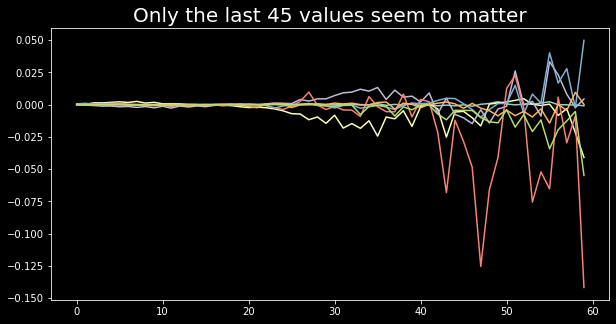

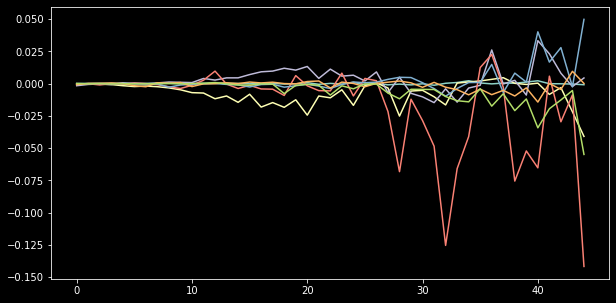

In [11]:
plt.figure(figsize = (10, 5))
plt.plot(IG_vals[0, :, :])
plt.title('Only the last 45 values seem to matter', fontsize = 20)
plt.pause(0.001)
plt.figure(figsize = (10, 5))
plt.plot(IG_vals[0, -45:, :]);

In [25]:
def compare_temporally_altered(first_n_days, x, model):
    y_hat_original = model(x)
    # replace first n out of 365 days with random values
    # and see how results change
    x_hypothesis = x.detach().clone()
    if len(x.shape)>3:
        x_hypothesis[:,:,:,:first_n_days]=torch.rand_like(x[:,:,:,:first_n_days])
    else:
        x_hypothesis[:, :first_n_days] = torch.rand_like(x[:, :first_n_days])
    y_hat_hypothesis = model(x_hypothesis)

    if len(x.shape)>3:
        x=reshape_gwn_output(x)
        x_hypothesis=reshape_gwn_output(x_hypothesis)
        y_hat_hypothesis=reshape_gwn_output(y_hat_hypothesis)
        y_hat_original=reshape_gwn_output(y_hat_original)

    fig, ax = plt.subplots(3, 2, figsize = (12, 9))

    ax[0,0].plot(x[0].detach(), color = 'white', alpha = 0.3)
    ax[0,0].set_ylim(-3, 5)
    ax[0,1].plot(x_hypothesis[0], color = 'white', alpha = 0.3)
    ax[0,1].set_ylim(-3, 5)
    ax[1,0].plot(y_hat_original[0].detach())
    ax[1,0].set_ylim(-1.5, 1.5)
    ax[1,1].plot(y_hat_hypothesis[0].detach())
    ax[1,1].set_ylim(-1.5, 1.5)
    ax[2,0].plot(y_hat_original[0, :].detach())
    ax[2,0].plot(y_hat_hypothesis[0, :].detach())
    ax[2,1].plot(y_hat_original[0, -60:].detach())
    ax[2,1].plot(y_hat_hypothesis[0, -60:].detach());

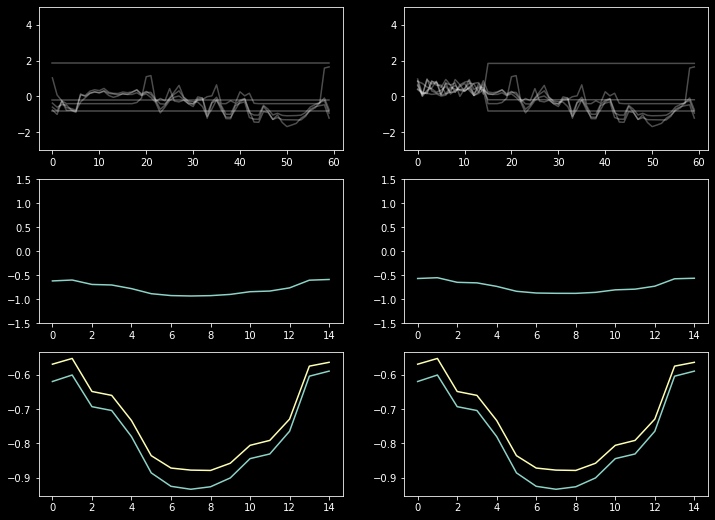

In [26]:
compare_temporally_altered(60-45, x, model)

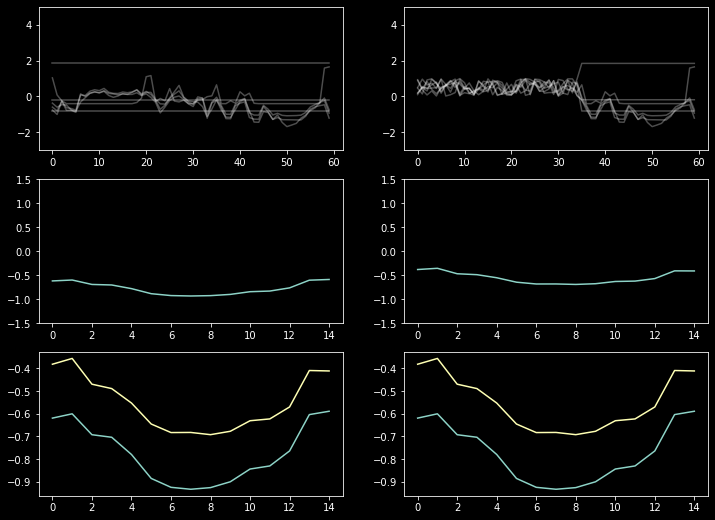

In [27]:
compare_temporally_altered(60-25, x, model)

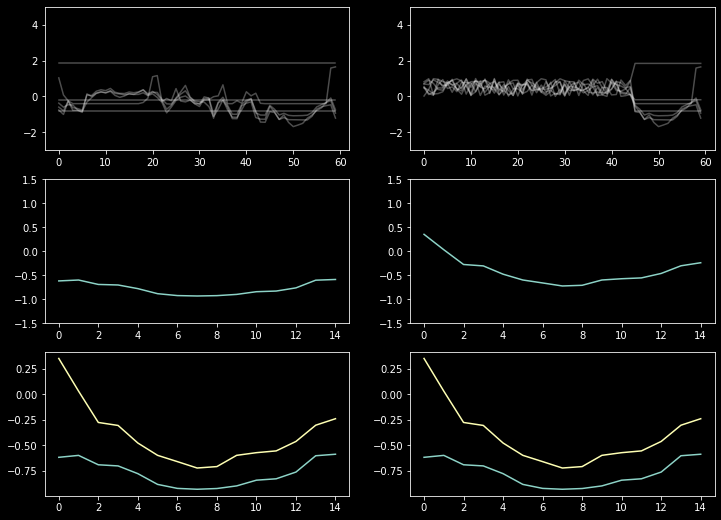

In [28]:
compare_temporally_altered(60-15,x, model)

The evidence appears to suggest that we can trust how IG explains importance temporally

# Apply XAI and visualize - can we trust IG spatially?

Similar experiment to the above, but seeing if we can trust what neighboring streams are identified as important

In [29]:
def compare_spatially_altered(seg_of_interest, important_segments, unimportant_segments, x, model):
    y_hat_original = model(x)

    x_hypothesis1 = x.detach().clone()
    for s in important_segments:
        if len(x.shape)>3:
            x_hypothesis1[:,:,s,...] = torch.rand_like(x[:,:,s,...])
        else:
            x_hypothesis1[s] = torch.rand_like(x[s])
    y_hat_hypothesis1 = model(x_hypothesis1)
    
    x_hypothesis2 = x.detach().clone()
    for s in unimportant_segments:
        if len(x.shape)>3:
            x_hypothesis2[:,:,s,...] = torch.rand_like(x[:,:,s,...])
        else:
            x_hypothesis2[s] = torch.rand_like(x[s])
    y_hat_hypothesis2 = model(x_hypothesis2)

    if len(x.shape)>3:
        x=reshape_gwn_output(x)
        x_hypothesis1=reshape_gwn_output(x_hypothesis1)
        x_hypothesis2=reshape_gwn_output(x_hypothesis2)
        y_hat_hypothesis1=reshape_gwn_output(y_hat_hypothesis1)
        y_hat_hypothesis2=reshape_gwn_output(y_hat_hypothesis2)
        y_hat_original=reshape_gwn_output(y_hat_original)


    fig, ax = plt.subplots(5, figsize = (10, 30))

    for seg in important_segments:
        ax[0].plot(x[seg].detach(), color = 'white', alpha = 0.3)
        ax[1].plot(x_hypothesis1[seg], color = 'white', alpha = 0.3)
        ax[1].set_title('Changed segment variable values | important')
        
    for seg in unimportant_segments:
        ax[0].plot(x[seg].detach(), color = 'white', alpha = 0.3)
        ax[0].set_title('Unchanged segment variable')
        ax[2].plot(x_hypothesis2[seg], color = 'white', alpha = 0.3)
        ax[2].set_title('Changed segment variable values | unimportant')
    
    ax[3].set_title('Predictions under different scenarios')
    ax[3].plot(y_hat_original[seg_of_interest, :].detach(),
               label = 'Original')
    ax[3].plot(y_hat_hypothesis1[seg_of_interest, :].detach(),
               label = 'Important segments changed',
               linestyle = '--')
    ax[3].plot(y_hat_hypothesis2[seg_of_interest, :].detach(),
               label = 'Unimportant segments changed',
               linestyle = '--')
    ax[3].legend()
    
    ax[4].set_title('Difference in predictions')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis1[seg_of_interest, :].detach(),
                 label = 'Important segments changed')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis2[seg_of_interest, :].detach(),
                 label = 'Unimportant segments changed')
    ax[4].legend()

In [30]:
spatial_focus = np.random.choice(455)

IG_vals = integrated_gradients(x, model, 2, baseline, temporal_focus = -1, spatial_focus = spatial_focus,gwn=True)

most_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[-5:]

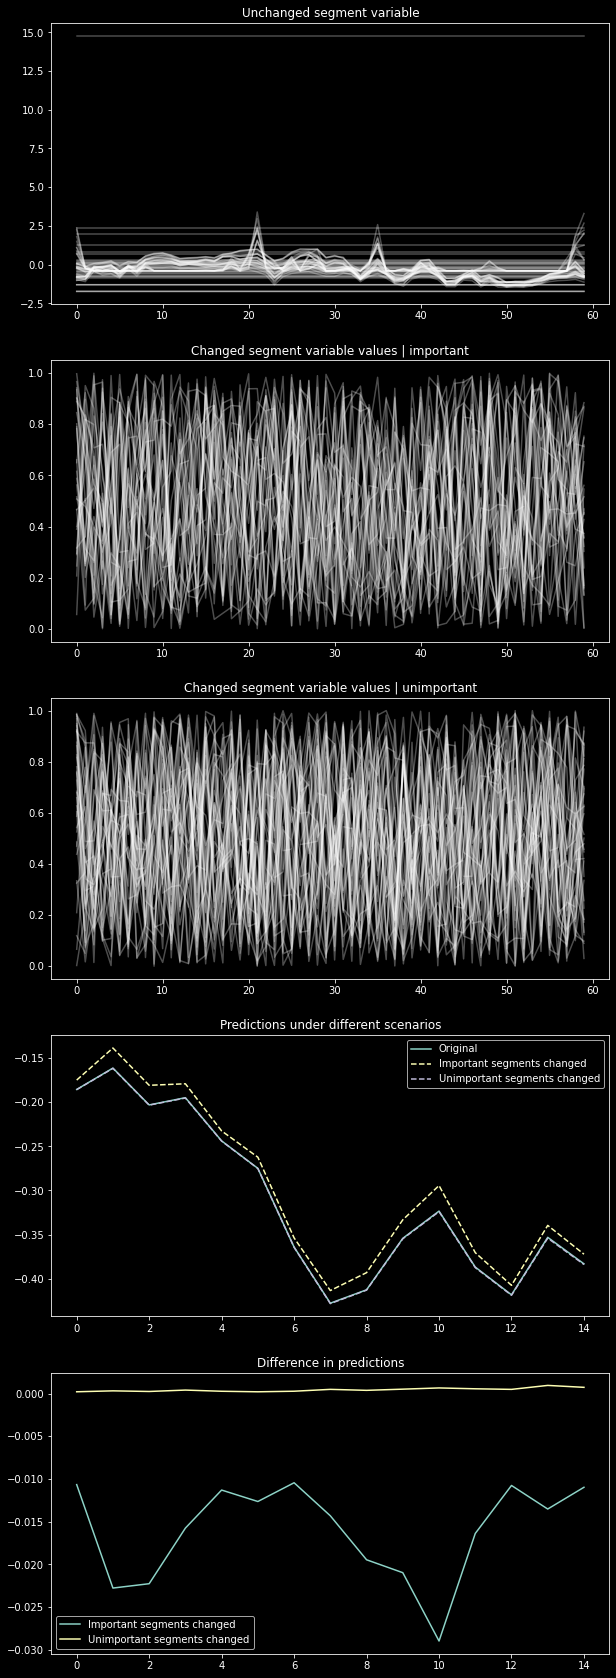

In [31]:
compare_spatially_altered(spatial_focus, most_relev, least_relev, x, model)

### A slightly more obvious difference in predictions

Spatial information doesn't seem to play a huge role, so hand-picking a more sensitive segment helps show the difference

In [32]:
spatial_focus = -1

IG_vals = integrated_gradients(x, model, 2, baseline, temporal_focus = -1, spatial_focus = spatial_focus, gwn=True)

most_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[-5:]

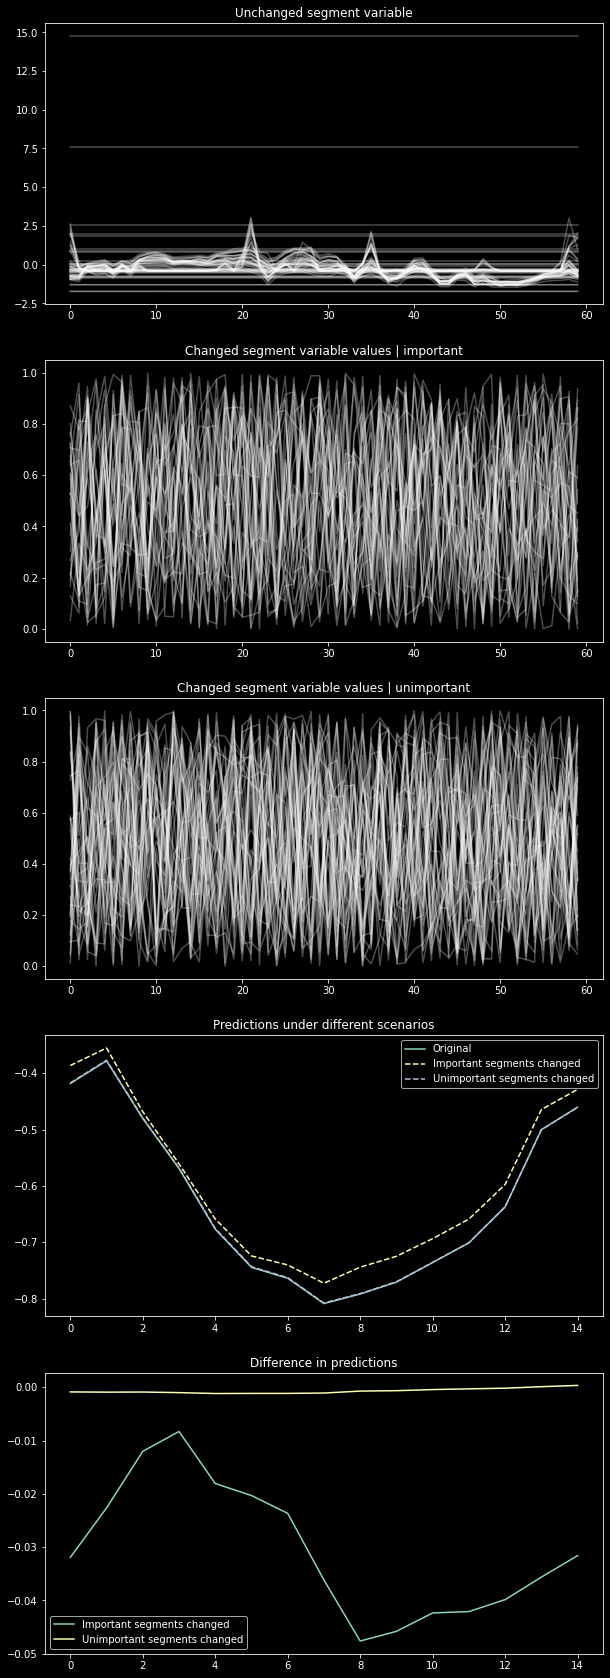

In [33]:
compare_spatially_altered(spatial_focus, most_relev, least_relev, x, model)

The evidence appears to suggest that we can trust how IG explains importance spatially